# Metalens Studies Automation
written by: Taylor Contreras, Feb 5 2021

This code controls the automation of the power meter and the motors to take measurements of the light intensity of a powermeter. An LED is aligned with a diffraction grating in front of the powermeter. The powermeter and LED are on tracks that can move vertically. This allows the calibration of the powermeter with no light and for the measurement of light intensity as a function of angle from the diffraction grating. 

See other notebooks for more details and tests (PyVisa_tutorial.ipynb, Ardruino_testing.ipynb, Motot_control_testing.ipynb)

In [2]:
from motor import Motor
from metalens_experiment_power import Experiment
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import csv
import pyvisa
import pyfirmata
import numpy as np
import time
import os
from ctypes import *
import sys
sys.path.append('C:\Program Files (x86)\IVI Foundation\VISA\WinNT\TLPM\Example\Python') 
from TLPM import TLPM
from scipy import interpolate, signal

## Save Data Function

In [411]:
file_name = 'run03_metalens_100ns_10sweeps.csv'
def SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle):
    with open('data/'+file_name, mode='w') as file:
                writer = csv.writer(file)
                
                writer.writerow(['position_lens'])
                writer.writerow([position_lens]) 
                writer.writerow(['position_led'])
                writer.writerow([position_led])
                writer.writerow(['positions_powermeter'])
                writer.writerow(positions_powermeter)
                writer.writerow(['maxes'])
                writer.writerow(maxes)
                writer.writerow(['rotation'])
                writer.writerow([rot_angle])

### Connect to the power meter

In [3]:
os.add_dll_directory(r"C:\Program Files (x86)\IVI Foundation\VISA\WinNT\Lib_x64\msc")
lib = cdll.LoadLibrary(r"C:\Program Files (x86)\IVI Foundation\VISA\WinNT\Bin\TLPM_32.dll")

tlPM = TLPM()
deviceCount = c_uint32()
tlPM.findRsrc(byref(deviceCount))

print("devices found: " + str(deviceCount.value))

resourceName = create_string_buffer(1024)

for i in range(0, deviceCount.value):
    tlPM.getRsrcName(c_int(i), resourceName)
    print(c_char_p(resourceName.raw).value)
    break

tlPM.close()

tlPM = TLPM()
tlPM.open(resourceName, c_bool(True), c_bool(True))
#tlPM.close()

devices found: 1
b'USB0::0x1313::0x8072::1916880::INSTR'


0

In [402]:
center0

284.245

### Connect to the Arduino

In [4]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board1 = pyfirmata.Arduino('COM3')
#board2 = pyfirmata.Arduino('COM6')

# must set iterator in order to take input (the button)
# make sure to run only once
it1 = pyfirmata.util.Iterator(board1)
it1.start()
#it2 = pyfirmata.util.Iterator(board2)
#it2.start()

### Make 'exp' to hold all the experiment objects and variables

In [5]:
# Creat powermeter and led motor class objects
powermeter_step_pin = 8
powermeter_dir_pin = 9
powermeter_button_pin = 6
led_step_pin = 10
led_dir_pin = 11
led_button_pin = 5
rot_step_pin = 3 #10
rot_dir_pin = 4 #11
lens_step_pin = 12
lens_dir_pin = 13
lens_button_pin = 5
board1.digital[powermeter_button_pin].mode = pyfirmata.INPUT
board1.digital[lens_button_pin].mode = pyfirmata.INPUT
powermeter_motor = Motor(board1, powermeter_step_pin, powermeter_dir_pin, 'powermeter', powermeter_button_pin) # pos dir is toward motor
led_motor = Motor(board1, led_step_pin, led_dir_pin, 'led') # pos dir is up
rot_motor = Motor(board1, rot_step_pin, rot_dir_pin, 'rot')
lens_motor = Motor(board1, lens_step_pin, lens_dir_pin, 'lens', lens_button_pin) # pos dir is toward motor

#powermeter_motor.CreatePositionFile()
#led_motor.CreatePositionFile()

In [6]:
exp = Experiment(rot_motor, lens_motor, led_motor, powermeter_motor, tlPM, align_with_file=True)

In [7]:
exp.PrintInfo()

---Experiment---
Motor name: lens
    Step pin: 12
    Dir pin: 13
    Button pin: 5
Motor name: powermeter
    Step pin: 8
    Dir pin: 9
    Button pin: 6
Motor name: rot
    Step pin: 3
    Dir pin: 4
    Button pin: 0
Motor name: led
    Step pin: 10
    Dir pin: 11
    Button pin: 0
--Alignments--
    powermeter_center = 58.335
    led_center = 307.7511211211212
    lens_center = 292.595
    lens_diam = 9.8
    mount_center = 177.0
    mount_left_outer_edge = 272.095
    mount_left_inner_edge = 283.095
    mount_diam = 10.6
    rot_center = 21713
    Number of Sweeps: 15


#### Tests and examples of movements and measurements

In [9]:
exp.Align('lens')

In [11]:
exp.Align()

In [60]:
exp.RotateLens(10)

In [86]:
exp.RotateLens(-10)

In [175]:
for i in range(50):
    exp.powermeter_motor.MoveMotor(-0.2)
    time.sleep(0.25)

In [105]:
exp.powermeter_motor.MoveMotor(10)

In [114]:
exp.lens_motor.MoveMotor(40)

In [102]:
exp.led_motor.MoveMotor(1)

In [438]:
exp.RotateLens(2)

In [771]:
exp.Align()

In [822]:
exp.lens_motor.MoveMotor(2)

[1.10920993e-07, 1.11158478e-07, 1.10881416e-07, 1.11079309e-07, 1.11000162e-07, 1.11039732e-07, 1.11039732e-07, 1.11000162e-07, 1.13776144e-08, 9.73643804e-11, 9.73643804e-11, 1.81923608e-11, 1.81923608e-11, 5.77924757e-11, -2.13795492e-11, 1.12147973e-07, 1.11633426e-07, 1.11514709e-07, 1.1139597e-07, 1.11039732e-07]


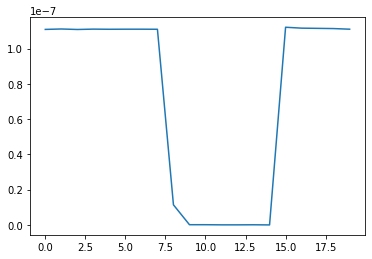

In [15]:
power_measurements = [exp.MeasurePower(1) for i in range(20)]
plt.plot(power_measurements)
print(power_measurements)

# Alignment

If you have replaced any pieces inside the dark box, you must first by eye align the powermeter, led, and lens centers. Then run the following alignments for the new experimental setup. The alignments take approximately 15 minutes.

### Alignment of powermeter and LED

'80/80'

Old powermeter center = 71.865
New powermeter center = 71.73


Text(0, 0.5, 'Peak to Peak voltage [V]')

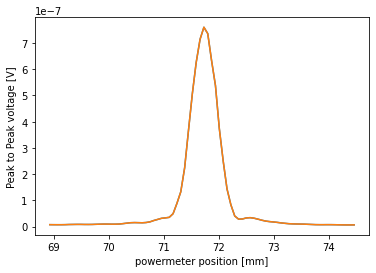

In [296]:
width=6. 
num_measurements=80
position_led, positions_powermeter, maxes = exp.FindPowerMeterCenter(width, num_measurements)
plt.plot(positions_powermeter, maxes)
plt.xlabel('powermeter position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

In [297]:
exp.Align('powermeter')

In [130]:
exp.lens_motor.MoveMotor(-40)

### Align the Lens to the LED

In [105]:
exp.alignments

{'powermeter_center': 78.08500000000001,
 'led_center': 310.55,
 'lens_center': 122.25,
 'lens_diam': 9.8,
 'mount_center': 177.0,
 'mount_left_outer_edge': 151.77,
 'mount_left_inner_edge': 157.37,
 'mount_diam': 10.6,
 'rot_center': 21693}

'50/50'

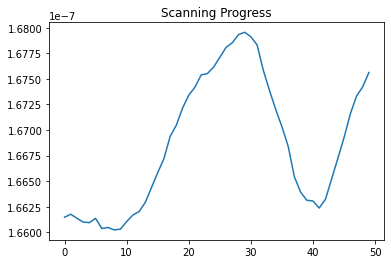

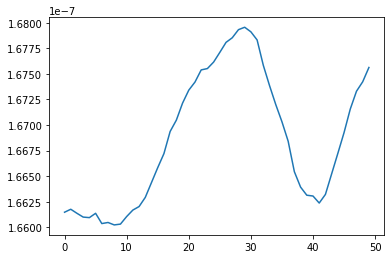

In [450]:
power = []
num_measurements = 50
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    power.append(exp.MeasurePower())
    if i > 0:
        plt.plot(power)
        plt.title('Scanning Progress')
        plt.show()
plt.plot(power)

'100/100'

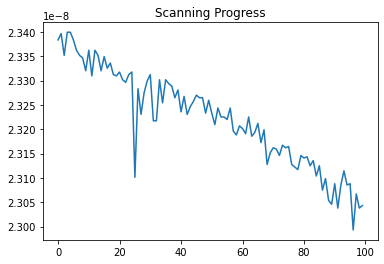

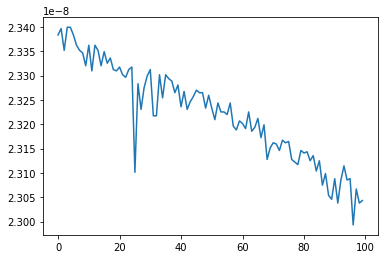

In [18]:
power = []
num_measurements = 100
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    power.append(exp.MeasurePower())
    if i > 0:
        plt.plot(power)
        plt.title('Scanning Progress')
        plt.show()
plt.plot(power)

'100/100'

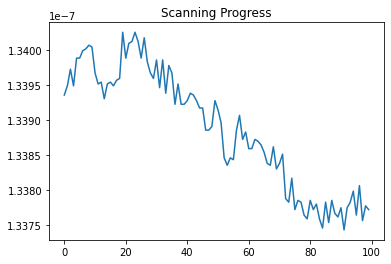

In [458]:
power = []
num_measurements = 100
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    power.append(exp.MeasurePower())
    if i > 0:
        plt.plot(power)
        plt.title('Scanning Progress')
        plt.show()

'100/100'

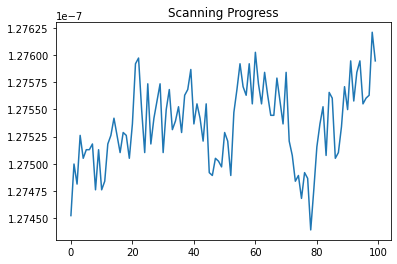

In [478]:
power = []
num_measurements = 100
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    power.append(exp.MeasurePower())
    if i > 0:
        plt.plot(power)
        plt.title('Scanning Progress')
        plt.show()

'100/100'

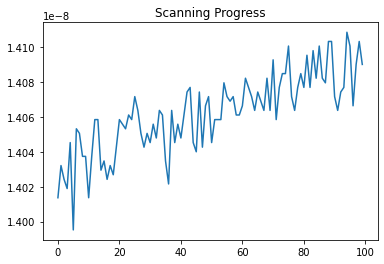

In [244]:
# Taylors test of laser stability
power = []
num_measurements = 100
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    power.append(exp.MeasurePower())
    if i > 0:
        
        plt.plot(power)
        plt.title('Scanning Progress')
        plt.show()

In [321]:
exp.Align()


Text(0, 0.5, 'Peak to Peak voltage [V]')

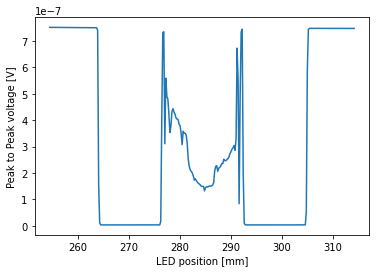

In [322]:
width=60.
num_measurements=300
positions_lens, maxes = exp.ScanLens(width, num_measurements)
plt.plot(positions_lens, maxes)
plt.xlabel('LED position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

Mount edges 263.83 276.23
Mount edges 292.23 304.83


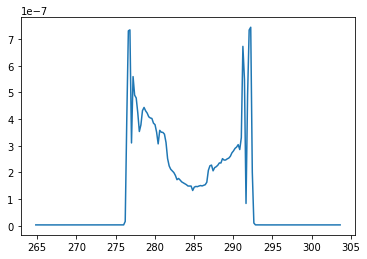

In [344]:
peak_width=6
prominence=6e-7
lens_data = exp.FindLensData(positions_lens, maxes, peak_width, prominence)
plt.plot(lens_data[0], lens_data[1])

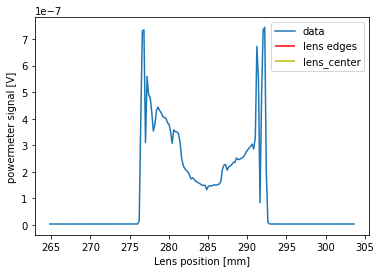

In [345]:
exp.FindLensCenter(lens_data, mount_prominence=60.0e-8, glass_prominence=3e-7)

In [346]:
exp.alignments

{'powermeter_center': 71.73,
 'led_center': 310.9,
 'lens_center': 284.23,
 'lens_diam': 9.8,
 'mount_center': 177.0,
 'mount_left_outer_edge': 263.83,
 'mount_left_inner_edge': 276.43,
 'mount_diam': 10.6,
 'rot_center': 21606}

#### Only run if the data is too noisy

In [ ]:
from scipy import signal
b, a = signal.ellip(2, 0.1, 120, 0.125)  # Filter to be applied.
fgust = signal.filtfilt(b, a, lens_data[1], method="gust")
fpad = signal.filtfilt(b, a, lens_data[1], padlen=50)
plt.plot(lens_data[1], 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=4, label='gust')
plt.plot(fpad, 'c-', linewidth=1.5, label='pad')
plt.legend(loc='best')
plt.show()

smoothed_maxes = fgust

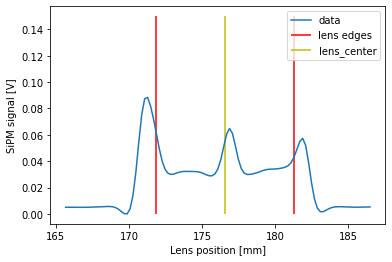

In [46]:
smoothed_lens_data = [lens_data[0], smoothed_maxes]
exp.FindLensCenter(smoothed_lens_data)

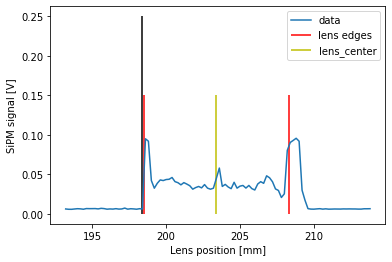

In [77]:
plt.plot(lens_data[0], lens_data[1], label='data')
plt.vlines(exp.alignments['lens_center'] - exp.alignments['lens_diam']/2., 0,.15, color='r', label='lens edges')
plt.vlines(exp.alignments['lens_center'] + exp.alignments['lens_diam']/2., 0, .15, color='r')
plt.vlines(exp.alignments['lens_center'], 0, .15, color='y', label='lens_center')
plt.vlines(exp.alignments['mount_left_inner_edge'], 0., .25, color='k')
plt.xlabel('Lens position [mm]')
plt.ylabel('powermeter signal [V]')
plt.legend()
plt.show()

In [270]:
exp.Align()

### Align the lens do be perpindicular with the beam
You must make sure the rotation motor is connected and  not the LED motor.

In [429]:
exp.Align()

In [419]:
width = 20.
num_measurements = 50
exp.lens_motor.MoveMotor(exp.alignments['mount_left_outer_edge'] - exp.lens_motor.GetCurrentPosition())
positions_lens, maxes = exp.ScanLens(width, num_measurements)

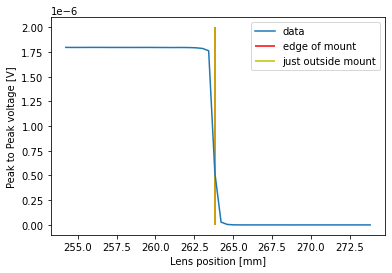

In [435]:
buffer = 0.

plt.plot(positions_lens, maxes, label='data')
plt.vlines(exp.alignments['mount_left_outer_edge'], 0, 2e-6, 'r', label='edge of mount')
plt.vlines(exp.alignments['mount_left_outer_edge']-buffer, 0, 2e-6, 'y', label='just outside mount')
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.legend()
plt.show()

'Rot step: 100/100'

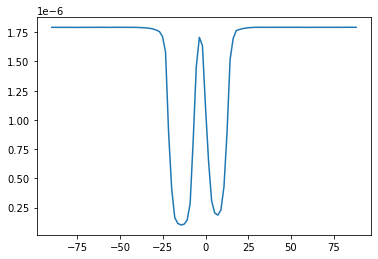

In [436]:
exp.lens_motor.MoveMotor(exp.alignments['mount_left_outer_edge'] - buffer - exp.lens_motor.GetCurrentPosition())
rot_data = exp.ScanRotation(180,100)
plt.plot((rot_data[:,0] - rot_data[len(rot_data[:,0])//2,0])*(1.8/8.), rot_data[:,1])
#exp.lens_motor.MoveMotor(-(exp.alignments['mount_left_outer_edge'] - buffer - exp.lens_motor.GetCurrentPosition()))

Rotated 3.6 to align


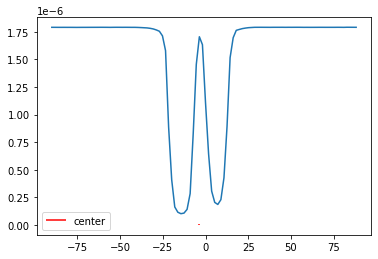

21578
Rotated 3.6 to align


In [438]:
old_center = exp.alignments['rot_center']
exp.FindLensRotationAlignment(rot_data, prominence=1e-6)
print(exp.alignments['rot_center'])
exp.WriteAlignment()
print('Rotated '+str((old_center - exp.alignments['rot_center'])*(1.8/8.))+' to align')

In [439]:
old_center = exp.alignments['rot_center']
exp.rot_motor.MoveMotor(old_center-exp.rot_motor.GetCurrentNumSteps())

In [440]:
exp.Align('rot')


In [518]:
exp.RotateLens(10)

In [105]:
exp.lens_motor.MoveMotor(-10)

### Align LED in vertical direction to lens

#### ----- Warning -----
You must make sure the LED motor is connected, rather than the rotation motor.

In [19]:
exp.SwitchMotor('led')

Manually connect led motor and disconnect rot motor


In [147]:
exp.Align()

Rotation motor is off. Switch motors to align


In [20]:
width = 10.
num_measurements = 30
buffer = 0.0
exp.lens_motor.MoveMotor(exp.alignments['mount_left_inner_edge'] - exp.lens_motor.GetCurrentPosition() + buffer)
#exp.Align()
#exp.lens_motor.MoveMotor(-5)
positions_lens, maxes = exp.ScanLens(width, num_measurements)
#exp.lens_motor.MoveMotor(5)

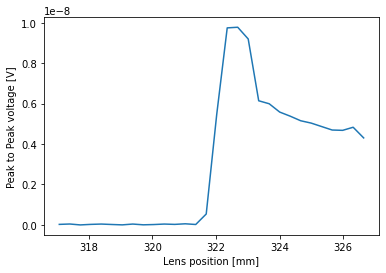

In [21]:
plt.plot(positions_lens, maxes, label='data')
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.show()

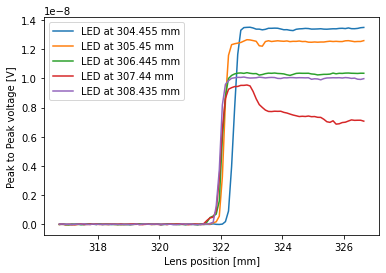

In [22]:
led_scan_width = 5.
lens_scan_width = 10.
num_measurements_led = 5
num_measurements_lens = 100
led_data = exp.ScanLED(led_scan_width, lens_scan_width, num_measurements_led, num_measurements_lens)

for led_step in led_data:
    plt.plot(led_step[0], led_step[1], label='LED at '+str(led_step[2])+' mm')
plt.xlabel('Lens position [mm]')
plt.legend()
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.show()

c:\users\owner\appdata\local\programs\python\python38-32\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


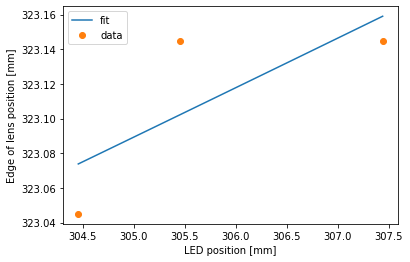

LED Center = -11.258788219142826


In [25]:
exp.FindLEDCenter(led_data, prominence=0.02e-8, guess=[5., 306, 323])

In [125]:
exp.Align()

LED motor is off. Switch motors to align


In [80]:
exp.RotateLens(10)

#### Use this code if the data is particulalry noisy and you are having trouble finding peaks

In [187]:
from scipy import signal
b, a = signal.ellip(6, 0.01, 120, 0.125)  # Filter to be applied.
fgust = signal.filtfilt(b, a, maxes, method="gust")
fpad = signal.filtfilt(b, a, maxes, padlen=50)
plt.plot(maxes, 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=4, label='gust')
plt.plot(fpad, 'c-', linewidth=1.5, label='pad')
plt.legend(loc='best')
plt.show()

smoothed_maxes = fgust

ValueError: The length of the input vector x must be greater than padlen, which is 50.

In [188]:
np.shape(maxes)

(30,)

# Runs

In [78]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


'50/50'

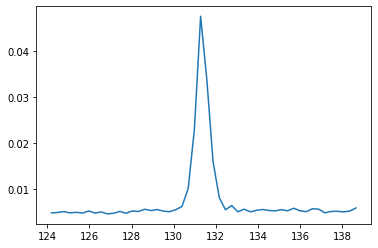

In [118]:
exp.Align()
position_led, positions_powermeter, maxes = exp.ScanMaxes(width=15., num_measurements=50)
plt.plot(positions_powermeter, maxes)

'100/100'

Total run time = 2.434846905867259


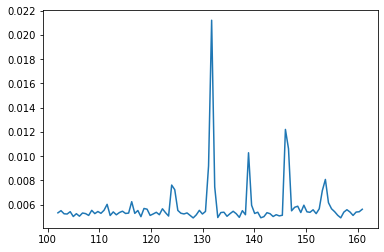

In [122]:
start_time = time.time()
exp.Align()
exp.lens_motor.MoveMotor(3)
position_led, positions_powermeter, maxes = exp.ScanMaxes(width=60., num_measurements=100)
plt.plot(positions_powermeter, maxes)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'100/100'

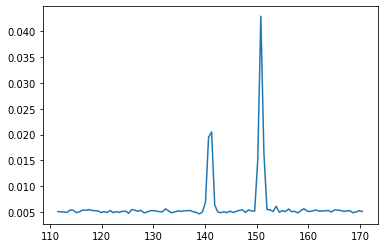

In [189]:
exp.Align()
exp.RotateLens(180.)
exp.lens_motor.MoveMotor(4)
position_led, positions_powermeter, maxes = exp.ScanMaxes(width=60., num_measurements=100)
plt.plot(positions_powermeter, maxes)

# Take dark noise data

'200/200'

NameError: name 'SaveScanMaxesData' is not defined

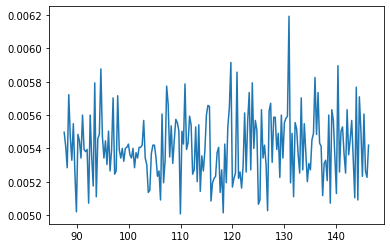

In [119]:
# Take data with led spot on the substrate
run_num = 576
powermeter_scan_width = 60
powermeter_num_measurements = 200
rot_angle = 0.0
base_file_name = '_darknoise_100ns_15sweeps.csv'
file_name = 'run'+str(run_num)+base_file_name

position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements)
plt.plot(positions_powermeter, maxes)
position_lens = exp.lens_motor.GetCurrentPosition()

SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle)

## Take air reference data

'200/200'

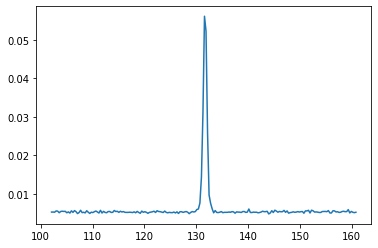

In [137]:
# Take data with led spot on the substrate
run_num = 1418
powermeter_scan_width = 60
powermeter_num_measurements = 200
rot_angle = 0.0
#base_file_name = '_metalens_100ns_15sweeps.csv'
file_name = 'run'+str(run_num)+base_file_name

exp.Align()
exp.lens_motor.MoveMotor(-40)
position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements)
exp.lens_motor.MoveMotor(40)
plt.plot(positions_powermeter, maxes)
position_lens = exp.lens_motor.GetCurrentPosition()

SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle)

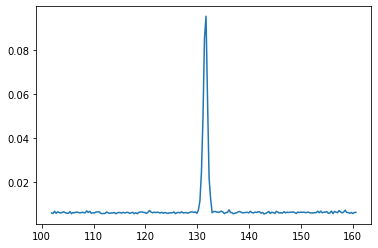

In [78]:
plt.plot(positions_powermeter, maxes)
#plt.xlim(115,120)
plt.show()

'200/200'

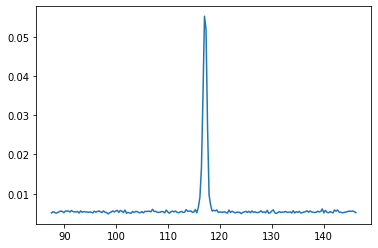

In [75]:
# Take data with led spot on the substrate
#run_num = 575
powermeter_scan_width = 60
powermeter_num_measurements = 200
rot_angle = 0.0
#base_file_name = '_metalens_100ns_15sweeps.csv'
#file_name = 'run'+str(run_num)+base_file_name

exp.Align()
exp.lens_motor.MoveMotor(-40)
position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements)
exp.lens_motor.MoveMotor(40)
plt.plot(positions_powermeter, maxes)
position_lens = exp.lens_motor.GetCurrentPosition()

#SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle)

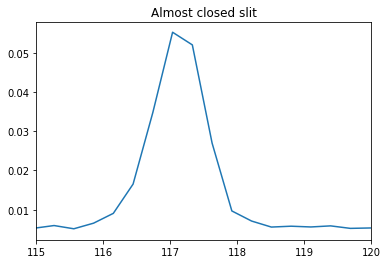

In [77]:
plt.plot(positions_powermeter, maxes)
plt.title('Almost closed slit')
plt.xlim(115,120)
plt.show()

## Take substrate reference data

In [139]:
# For a scan with just substrate, align the center of lens based on mount edges
from scipy import signal
peaks, _ = signal.find_peaks(lens_data[1], prominence=.1)
widths = signal.peak_widths(lens_data[1], peaks)

exp.alignments['lens_center'] = (lens_data[0][int(widths[3])] + lens_data[0][int(widths[2])])/2.

In [174]:
# Run as of 5/26/2022
start_time = time.time()
num_rots = 4
drot = 20
lens_scan_width = 6.
lens_num_measurements = 3 #120
lens_dx = lens_scan_width / max((lens_num_measurements-1),1)
powermeter_scan_width = 8
powermeter_num_measurements = 40
base_file_name = '_substrate_100ns_15sweeps.csv'
run_num = 1419

exp.Align()
current_rot = -drot*num_rots/2
exp.RotateLens(current_rot)
for rot in range(num_rots+1):
    
    exp.Align('lens')
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for lens_scan in range(lens_num_measurements):
    
        exp.Align('powermeter')
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
        exp.lens_motor.MoveMotor(lens_dx)
        run_num += 1
        #print(rot, lens_scan, current_rot, lens_dx)

    exp.RotateLens(drot)  
    current_rot += drot

exp.Align('rot')
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

LED motor is off. Switch motors to align
Total run time = 13.07053189277649


In [194]:
exp.lens_motor.MoveMotor(-7)

In [52]:
from scipy import signal


## Rotation and symmetry runs

In [94]:
# Running over many lens positions to check lens symmetry
start_time = time.time()
lens_scan_width = 5. # mm (lens radius)
num_scans = 5
powermeter_scan_width = 60
powermeter_num_measurements = 200
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 500
dx_lens = lens_scan_width / num_scans
lens_pos = 0.0
rot_width = 30.
rot_scans = 3
drot = rot_width/rot_scans
exp.Align()
for rot in range(rot_scans):

    for i in range(num_scans):
        clear_output(wait=True)
        display('Scan: '+str(i+1)+"/"+str(num_scans)+', rot: '+str(rot+1)+'/'+str(rot_scans))
        
        exp.Align('lens')
        exp.Align('powermeter')
        exp.lens_motor.MoveMotor(dx_lens*i)
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        rot_angle = rot * drot
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle)
        run_num += 1

        exp.Align('lens')
        exp.Align('powermeter')
        exp.lens_motor.MoveMotor(-dx_lens*i)
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle)
        run_num += 1

    exp.RotateLens(drot)
    
end_time = time.time()
exp.RotateLens(-rot_width)

'Scan: 5/5, rot: 3/3'

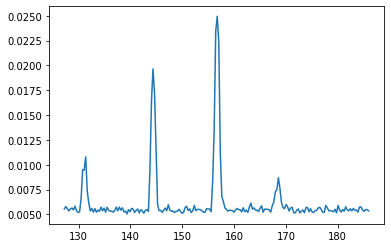

In [323]:
plt.plot(positions_powermeter, maxes)

# Runs for Adam
Very fine grained runs over entire metalens

In [127]:
# Running over many lens positions to check lens symmetry
start_time = time.time()
lens_scan_width = 2. # mm (lens radius)
num_scans = 20
powermeter_scan_width = 120
powermeter_num_measurements = 600
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 531
dx_lens = lens_scan_width / num_scans

exp.Align()
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for i in range(num_scans):
    clear_output(wait=True)
    display('Scan: '+str(i+1)+"/"+str(num_scans))

    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, 0.0)
    #print(position_lens)
    #plt.plot(positions_powermeter, maxes, label=position_lens)
    #plt.legend()
    #plt.show()
    exp.lens_motor.MoveMotor(dx_lens)
    run_num += 1
    
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'Scan: 20/20'

Total run time = 353.4198785742124


In [128]:
# Running over many lens positions to check lens symmetry
start_time = time.time()
lens_scan_width = 24. # mm (lens radius)
num_scans = 24
powermeter_scan_width = 120
powermeter_num_measurements = 600
base_file_name = '_metalens_100ns_15sweeps.csv'
#run_num = 531
dx_lens = lens_scan_width / num_scans

exp.Align()
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for i in range(num_scans):
    clear_output(wait=True)
    display('Scan: '+str(i+1)+"/"+str(num_scans))

    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, 0.0)
    #print(position_lens)
    #plt.plot(positions_powermeter, maxes, label=position_lens)
    #plt.legend()
    #plt.show()
    exp.lens_motor.MoveMotor(dx_lens)
    run_num += 1
    
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'Scan: 24/24'

Total run time = 425.63242812951404


In [21]:
# Special run to get fine grained data at center, at lens edge, and at mount edge
start_time = time.time()
num_rots = 2
max_rot = 20.
drot = max_rot / (num_rots-1)
lens_scan_width = 3. # mm (lens radius)
num_lens_scans = 30
dx_lens = lens_scan_width / num_lens_scans
powermeter_scan_width = 120
powermeter_num_measurements = 600
powermeter_scan_width_less = 60
powermeter_num_measurements_less = 300
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 576

exp.Align()
for rot in range(num_rots):
    current_rot = drot*rot
    
    exp.Align('lens')
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for i in range(num_lens_scans):
        exp.Align('powermeter')
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width_less, num_measurements=powermeter_num_measurements_less, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
        run_num += 1
        exp.lens_motor.MoveMotor(dx_lens)  

    # Take edge of lens data
    exp.lens_motor.MoveMotor(exp.alignments['mount_left_inner_edge'] - exp.lens_motor.GetCurrentPosition())
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for i in range(num_lens_scans):
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width_less, num_measurements=powermeter_num_measurements_less, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
        run_num += 1
        exp.lens_motor.MoveMotor(dx_lens)

    # Take edge of mount data
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    exp.lens_motor.MoveMotor(exp.alignments['mount_left_outer_edge'] - exp.lens_motor.GetCurrentPosition())
    for i in range(num_lens_scans):
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width_less, num_measurements=powermeter_num_measurements_less, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
        run_num += 1
        exp.lens_motor.MoveMotor(dx_lens)
    
    exp.RotateLens(drot)  

exp.RotateLens(-drot*num_rots)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

LED motor is off. Switch motors to align
Total run time = 1157.215026072661


In [47]:
center

203.815

In [75]:
exp.lens_motor.MoveMotor(center - exp.lens_motor.GetCurrentPosition())

In [52]:
exp.lens_motor.GetCurrentPosition()

203.815

In [312]:
exp.Align('rot')

In [39]:
exp.lens_motor.MoveMotor(50.)

In [143]:
# Run as of 5/4/2022
start_time = time.time()
num_rots = 2
drot = 20
lens_scan_width = 12.
lens_num_measurements = 3 #120
lens_dx = lens_scan_width / lens_num_measurements
powermeter_scan_width = 60
powermeter_num_measurements = 120
base_file_name = '_substrate_100ns_15sweeps.csv'
run_num = 1058

exp.Align()
current_rot = -drot*num_rots/2
exp.RotateLens(current_rot)
for rot in range(num_rots+1):
    
    exp.Align('lens')
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    for lens_scan in range(lens_num_measurements):
    
        exp.Align('powermeter')
        position_lens = exp.lens_motor.GetCurrentPosition()
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
        exp.lens_motor.MoveMotor(lens_dx)
        run_num += 1
        #print(rot, lens_scan, current_rot)

    exp.RotateLens(drot)  
    current_rot += drot

exp.Align('rot')
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

LED motor is off. Switch motors to align
0 0 -20.0
0 1 -20.0
0 2 -20.0
1 0 0.0
1 1 0.0
1 2 0.0
2 0 20.0
2 1 20.0
2 2 20.0
Total run time = 1.2271172324816386


## Strip Metalenses

In [444]:
exp.alignments

{'powermeter_center': 78.08500000000001,
 'led_center': 310.4680630630631,
 'lens_center': 284.4,
 'lens_diam': 9.8,
 'mount_center': 177.0,
 'mount_left_outer_edge': 272.825,
 'mount_left_inner_edge': 278.625,
 'mount_diam': 10.6,
 'rot_center': 21669}

In [373]:
exp.Align()


In [294]:
exp.lens_motor.MoveMotor(40)

#### Scanning the LED up and down to find lens center in vertical position

'Scan: 30/30'

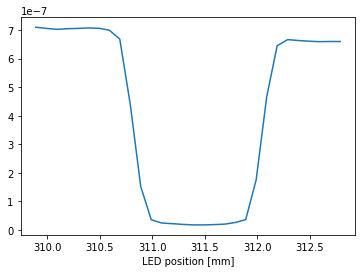

In [381]:
led_scan_width = 3.
#exp.lens_motor.MoveMotor(2)

dx_led = 0.1
num_led_steps = int(led_scan_width / dx_led)
maxes = []
led_positions = []

exp.led_motor.MoveMotor(-led_scan_width/2.)
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan: '+str(step+1)+"/"+str(num_led_steps))
    maxes.append(exp.MeasurePower())
    led_positions.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)
exp.led_motor.MoveMotor(-led_scan_width/2.)
plt.plot(led_positions, np.array(maxes))
plt.xlabel('LED position [mm]')
plt.show()

In [716]:
exp.led_motor.MoveMotor(4.)

In [382]:
peaks, _ = signal.find_peaks(np.array(maxes)*-1, prominence=2e-7)
widths = signal.peak_widths(np.array(maxes)*-1, peaks)
led_center = (led_positions[int(widths[2])] + led_positions[int(widths[3])])/2.
print(led_center)

311.39


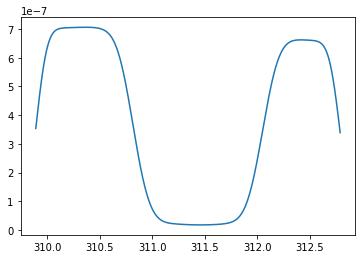

311.4372472472472


In [383]:
meio = (led_positions[len(led_positions)-1]+led_positions[0])/2
x = np.linspace(led_positions[0], led_positions[len(led_positions)-1], 1000)
FWHM = 0.2
sigma=FWHM/2.3548
G = np.exp(-(x-meio)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
G = G/sum(G)

interp = interpolate.interp1d(led_positions, maxes, kind = "linear")
maxes3 = interp(x)
maxes3 = np.convolve(maxes3, G, mode='same')

plt.plot(x,maxes3)
plt.show()


peaks, _ = signal.find_peaks(np.array(maxes3)*-1, prominence=2e-8)
widths = signal.peak_widths(np.array(maxes3)*-1, peaks)
led_center = (x[int(widths[2])] + x[int(widths[3])])/2.
print(led_center)

In [384]:
exp.led_motor.MoveMotor(led_center - exp.led_motor.GetCurrentPosition())
exp.alignments['led_center'] = led_center
led_center

311.4372472472472

In [385]:
exp.Align('lens')

#### Scanning across lens  to find center of lens horizontally

In [215]:
def StripFindCenter(lens_scan_width,dx_lens,rot,prom):
    exp.Align('powermeter')


    num_lens_steps = int(lens_scan_width / dx_lens)
    maxes = []
    lens_positions = []
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)

    for step in range(num_lens_steps):
        clear_output(wait=True)
        display('Scan: '+str(step+1)+"/"+str(num_lens_steps))
    
        maxes.append(exp.MeasurePower())
        lens_positions.append(exp.lens_motor.GetCurrentPosition())
        exp.lens_motor.MoveMotor(dx_lens)
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    plt.plot(lens_positions, np.array(maxes))
    plt.show()
    indices = signal.find_peaks(np.array(maxes), prominence=prom)[0]
    lens_center_x =lens_positions[int(indices[0])]
    #if rot>0:
        #exp.Align('rot')
    return(lens_center_x)

'Scan: 100/100'

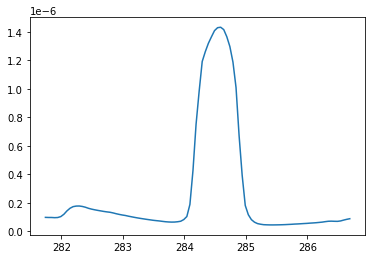

In [415]:
exp.Align()
center0 = StripFindCenter(5.,0.05,0,5e-9)



In [416]:
center0 = 284.245
exp.alignments['lens_center'] = center0
print(center0)
exp.Align()

284.245


'Scan: 20/20'

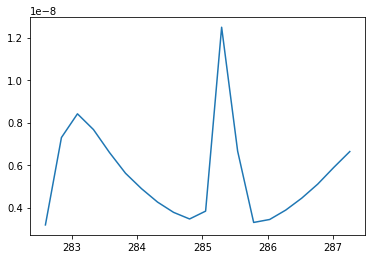

In [209]:
## Find metalens center as function of angle of rotation

exp.Align()
drot = 2
angle_scan = 10
num_rot_step = int(angle_scan / drot)+1

lens_rot = []
exp.RotateLens(-angle_scan/2)
for step in range(num_rot_step):
    lens_rot.append(StripFindCenter(5.,0.25,drot,1e-9))
    exp.RotateLens(drot)



285.6

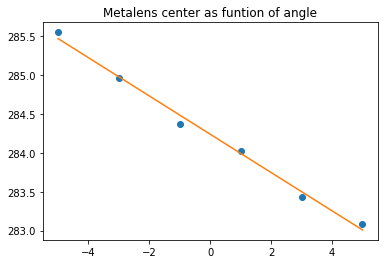

In [214]:
exp.Align()
rotarray = np.linspace(-5,5,6)
a_rot, b_rot = np.polyfit(rotarray,lens_rot, 1)

rotarray = np.linspace(-angle_scan/2,angle_scan/2,num_rot_step)
plt.plot(rotarray,lens_rot,'o')
plt.title('Metalens center as funtion of angle')
plt.plot(rotarray,a_rot*rotarray+b_rot)
angle =0
a_rot*angle+b_rot
center0

In [47]:
peaks, _ = signal.find_peaks(np.array(maxes)*-1, prominence=4.5e-7)
widths = signal.peak_widths(np.array(maxes)*-1, peaks)
lens_center_x = lens_positions[int(widths[3][1])]
lens_center_x

NameError: name 'maxes' is not defined

In [772]:
print(lens_rot)
lens_center_x = np.array(lens_rot)

[284.65500000000003]


In [885]:

exp.Align()

In [723]:
exp.lens_motor.GetCurrentPosition()

284.62

In [388]:
exp.Align()

#### Test split lens orientation

In [389]:
led_scan_width = 5.
dx_led = .1
num_led_steps = int(led_scan_width / dx_led)
lens_offset = .1 # mm
lens_scan_width = 2.
dx_lens = .5
num_lens_steps = int(lens_scan_width / dx_lens)
maxes = []
lens_positions = []
led_positions = []

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(-lens_offset)
for lens_step in range(num_lens_steps):
    exp.led_motor.MoveMotor(-led_scan_width/2.)
    lens_positions.append(exp.lens_motor.GetCurrentPosition())
    for step in range(num_led_steps):
        clear_output(wait=True)
        display('Scan 1/3: '+str(step+1)+"/"+str(num_led_steps))
        maxes_l.append(osc.MeasurePeaktoPeak(scope, 15))
        led_positions_l.append(exp.led_motor.GetCurrentPosition())
        exp.led_motor.MoveMotor(dx_led)
    exp.led_motor.MoveMotor(-led_scan_width/2.)

NameError: name 'lens_center_x' is not defined

In [673]:
exp.lens_motor.MoveMotor(40)

In [390]:
exp.Align()
led_scan_width = 3.
dx_led = .1
num_led_steps = int(led_scan_width / dx_led)
lens_offset = 3. # mm
maxes_l = []
led_positions_l = []
maxes_c = []
led_positions_c = []
maxes_r = []
led_positions_r = []
correction = 0.
exp.lens_motor.MoveMotor(-lens_offset)
exp.led_motor.MoveMotor(-led_scan_width/2.)
lens_pos_l = exp.lens_motor.GetCurrentPosition()
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan 1/3: '+str(step+1)+"/"+str(num_led_steps))
    maxes_l.append(exp.MeasurePower())
    led_positions_l.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)

exp.Align('lens')
exp.Align('led')
exp.led_motor.MoveMotor(-led_scan_width/2.)
lens_pos_c = exp.lens_motor.GetCurrentPosition()
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan 2/3: '+str(step+1)+"/"+str(num_led_steps))
    maxes_c.append(exp.MeasurePower())
    led_positions_c.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)

exp.Align('led')
exp.lens_motor.MoveMotor(lens_offset)
exp.led_motor.MoveMotor(-led_scan_width/2.)
lens_pos_r = exp.lens_motor.GetCurrentPosition()
for step in range(num_led_steps):
    clear_output(wait=True)
    display('Scan 3/3: '+str(step+1)+"/"+str(num_led_steps))
    maxes_r.append(exp.MeasurePower())
    led_positions_r.append(exp.led_motor.GetCurrentPosition())
    exp.led_motor.MoveMotor(dx_led)
exp.led_motor.MoveMotor(-led_scan_width/2.)

'Scan 3/3: 30/30'

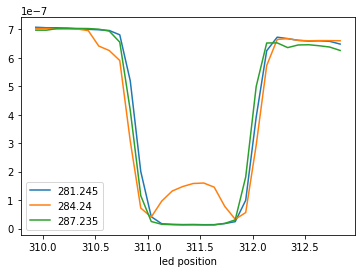

In [391]:
plt.plot(led_positions_l, maxes_l, label=str(lens_pos_l))
plt.plot(led_positions_l, maxes_c, label=str(lens_pos_c))
plt.plot(led_positions_l, maxes_r, label=str(lens_pos_r))
plt.xlabel('led position')
plt.legend()
plt.show()

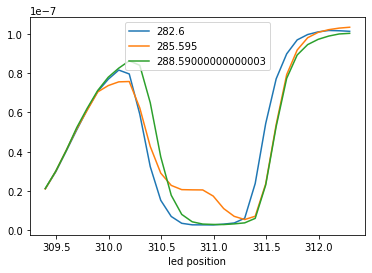

In [197]:
plt.plot(led_positions_l, maxes_l, label=str(lens_pos_l))
plt.plot(led_positions_l, maxes_c, label=str(lens_pos_c))
plt.plot(led_positions_l, maxes_r, label=str(lens_pos_r))
plt.xlabel('led position')
plt.legend()
plt.show()

In [398]:
exp.lens_motor.MoveMotor(-1)

In [587]:
exp.powermeter_motor.MoveMotor(-3)

In [399]:
exp.Align()

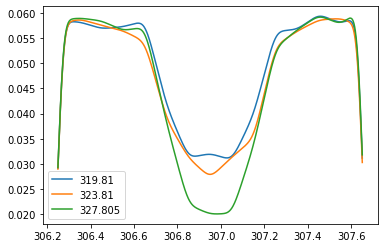

-0.046246246246255396

-0.07707707707709233

0.03083083083083693

-0.023123123123127698

-0.3312106516594931

In [2375]:
from scipy import interpolate

FWHM = 0.05
sigma=FWHM/2.3548

meio = (led_positions_l[len(led_positions_l)-1]+led_positions_l[0])/2
xl = np.linspace(led_positions_l[0], led_positions_l[len(led_positions_l)-1], 1000)
G = np.exp(-(xl-meio)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
G = G/sum(G)

xl = np.linspace(led_positions_l[0], led_positions_l[len(led_positions_l)-1], 1000)
interp = interpolate.interp1d(led_positions_l, maxes_l, kind = "linear")
maxes3l = interp(xl)
maxes3l = np.convolve(maxes3l, G, mode='same')

xc = np.linspace(led_positions_c[0], led_positions_c[len(led_positions_c)-1], 1000)
interp = interpolate.interp1d(led_positions_c, maxes_c, kind = "linear")
maxes3c = interp(xc)
maxes3c = np.convolve(maxes3c, G, mode='same')

xr = np.linspace(led_positions_r[0], led_positions_r[len(led_positions_r)-1], 1000)
interp = interpolate.interp1d(led_positions_r, maxes_r, kind = "linear")
maxes3r = interp(xr)
maxes3r = np.convolve(maxes3r, G, mode='same')

plt.plot(xc,maxes3l, label=str(lens_pos_l))
plt.plot(xc,maxes3c, label=str(lens_pos_c))
plt.plot(xc,maxes3r, label=str(lens_pos_r))
plt.legend()
plt.show()

indices = signal.find_peaks(np.array(maxes3r)*-1, prominence=0.005)[0]
peakr =xr[int(indices[0])]
indices = signal.find_peaks(np.array(maxes3c)*-1, prominence=0.005)[0]
peakc =xc[int(indices[0])]
indices = signal.find_peaks(np.array(maxes3l)*-1, prominence=0.005)[0]
peakl =xl[int(indices[0])]

display(peakr-peakl)
display(peakc-peakl)
display(peakr-peakc)

correction2 = (peakr-peakl)/(lens_offset*2)
display(correction2*lens_offset)

display(np.arctan(correction2)*180/np.pi)

### Test runs

In [302]:
exp.alignments


In [609]:
exp.Align('powermeter')
exp.powermeter_motor.MoveMotor(-FirstOrderDisplacement(3))

'40/40'

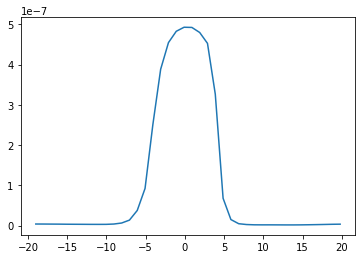

In [199]:
exp.Align()
position_lens = 2
angle = 0
exp.lens_motor.MoveMotor(position_lens)
first_order_pos = FirstOrderDisplacement_oblique(center0-exp.lens_motor.GetCurrentPosition(),angle,11.)

print(first_order_pos)
exp.RotateLens(angle)
exp.powermeter_motor.MoveMotor(first_order_pos)


position_led, positions_powermeter, maxes = exp.ScanPower(width=40., num_measurements=40)
plt.plot(positions_powermeter-np.array(exp.alignments['powermeter_center'])-first_order_pos, maxes)


In [999]:
exp.Align('rot')

-10.55958901308594


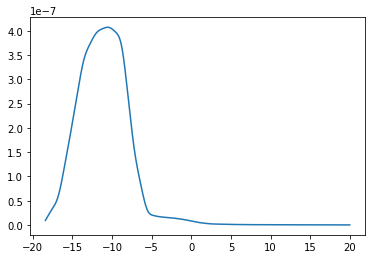

In [625]:
from scipy import interpolate

FWHM = 0.8
sigma=FWHM/2.3548

powermeter2 = positions_powermeter-np.array(exp.alignments['powermeter_center'])-first_order_pos
meio = (powermeter2[len(powermeter2)-1]+powermeter2[0])/2
xl = np.linspace(powermeter2[0], powermeter2[len(powermeter2)-1], 1000)
G = np.exp(-(xl-meio)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
G = G/sum(G)

interp = interpolate.interp1d(powermeter2, maxes, kind = "linear")
maxes3l = interp(xl)
maxes3l = np.convolve(maxes3l, G, mode='same')

plt.plot(xl,maxes3l)

indices = signal.find_peaks(np.array(maxes3l), prominence=1e-7)[0]
peakr =xl[int(indices[0])]
print(peakr)


In [634]:
from math import sin, tan
import scipy.optimize

def fun(x,*args):
        f = args[0]
        angle = args[1]
        D = args[2]
        d = args[3]
        theta = x[0]
        r = x[1]
        angle = angle*np.pi/180.
        y = [sin(theta)+r/np.sqrt(r**2+f**2)-sin(angle), d-D*tan(theta-angle)-r]
        return y
f = 7.
angle = 20
D = 118
d = peakr
x,y = scipy.optimize.fsolve(fun,np.array([0,0]),args =(f,angle,D,d))
print(x)
print(y)
y-position_lens

0.25448364005743634
0.6345117733784308


-2.365488226621569

In [668]:
exp.alignments

{'powermeter_center': 71.025,
 'led_center': 310.4680630630631,
 'lens_center': 284.42,
 'lens_diam': 9.8,
 'mount_center': 177.0,
 'mount_left_outer_edge': 272.825,
 'mount_left_inner_edge': 278.625,
 'mount_diam': 10.6,
 'rot_center': 21669}

In [666]:
print(new_center_lens)

284.2504923076925


In [665]:
exp.Align()

# Strip Metalens Runs

In [400]:
def FirstOrderDisplacement(lens_offset,powermeter_lens_distance):
    #powermeter_lens_distance = 10.8
    focal_length = 0.7
    return (- powermeter_lens_distance / focal_length + 1.) * lens_offset

In [401]:
def FirstOrderDisplacement_oblique(lens_offset,angle,powermeter_lens_distance):
    powermeter_lens_distance = powermeter_lens_distance*10 ## mm
    focal_length = 7. ##mm
    angle = angle*np.pi/180.
    theta = (-lens_offset / np.sqrt(lens_offset**2+focal_length**2)+np.sin(angle))
    if abs(theta)>=1.:
        return np.nan
    else:
        theta = np.arcsin(theta)
        return powermeter_lens_distance*np.tan(theta-angle)+lens_offset

In [409]:
exp.Align()
lens_offset = 3
dx=FirstOrderDisplacement_oblique(lens_offset,0.,10.)
print(dx)
#displace = round(122.25-exp.lens_motor.GetCurrentPosition()+lens_offset,2)
#print(displace)
exp.lens_motor.MoveMotor(lens_offset)
exp.powermeter_motor.MoveMotor(-dx)

-39.85714285714285


In [781]:
exp.powermeter_motor.MoveMotor(-1)

In [782]:
exp.alignments['powermeter_center'] = exp.powermeter_motor.GetCurrentPosition()
exp.Align('powermeter')

In [169]:
exp.Align('rot')

'150/150'

Total run time = 133.7892676671346


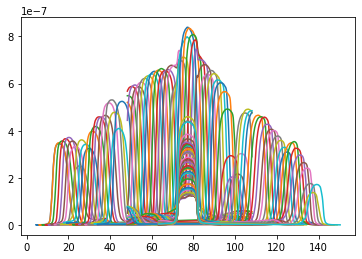

In [171]:
# Run as of 5/27/2022
start_time = time.time()
lens_scan_width = 8.
lens_dx = .1
lens_num_measurements = int( lens_scan_width / lens_dx)
powermeter_dx = 0.2
base_file_name = '_stripmetalens_pm_20ns_15sweeps.csv'
run_num = 2085
current_rot = 0.0
lens_center_x = exp.alignments['lens_center']

exp.Align()
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for lens_scan in range(lens_num_measurements):

    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
       
    if abs(position_lens - lens_center_x) <= 2.0:
        powermeter_scan_width = 60. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led, positions_powermeter, maxes = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    else:
        powermeter_scan_width = 30. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led1, positions_powermeter1, maxes1 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
    
        first_order_pos = FirstOrderDisplacement(lens_center_x - exp.lens_motor.GetCurrentPosition())
        exp.powermeter_motor.MoveMotor(first_order_pos)
        powermeter_scan_width = 30. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led2, positions_powermeter2, maxes2 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        
        position_led =  [position_led1 , position_led2]
        positions_powermeter = positions_powermeter1 + positions_powermeter2
        maxes = maxes1+maxes2
        file_name = 'run'+str(run_num)+base_file_name       
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    exp.lens_motor.MoveMotor(lens_dx)
    plt.plot(np.array(positions_powermeter), maxes)
    
    run_num += 1
    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'70/70'

Total run time = 88.00612289110819


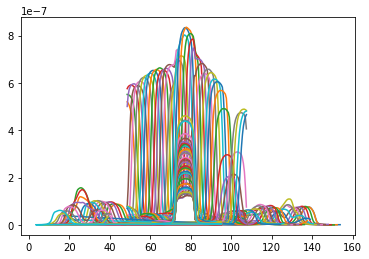

In [182]:
# Run as of 7/13/2022 -> -1 Order measurement
start_time = time.time()
lens_scan_width = 8.
lens_dx = .1
lens_num_measurements = int( lens_scan_width / lens_dx)
powermeter_dx = 0.5
base_file_name = '_stripmetalens_pm_20ns_15sweeps.csv'
run_num = 2245
current_rot = 0.0
lens_center_x = exp.alignments['lens_center']

exp.Align()
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for lens_scan in range(lens_num_measurements):

    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
       
    if abs(position_lens - lens_center_x) <= 2.0:
        powermeter_scan_width = 60. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led, positions_powermeter, maxes = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    else:
        powermeter_scan_width = 35. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led1, positions_powermeter1, maxes1 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
    
        first_order_pos = -FirstOrderDisplacement(lens_center_x - exp.lens_motor.GetCurrentPosition())
        exp.powermeter_motor.MoveMotor(first_order_pos)
        powermeter_scan_width = 35. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led2, positions_powermeter2, maxes2 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        
        position_led =  [position_led1 , position_led2]
        positions_powermeter = positions_powermeter1 + positions_powermeter2
        maxes = maxes1+maxes2
        file_name = 'run'+str(run_num)+base_file_name       
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    exp.lens_motor.MoveMotor(lens_dx)
    plt.plot(np.array(positions_powermeter), maxes)
    
    run_num += 1
    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'80/80'

Total run time = 98.48237487872441


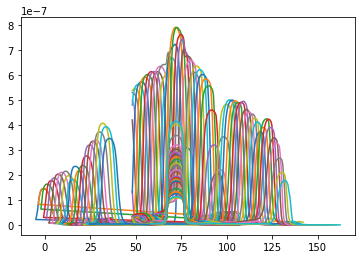

In [638]:
# Run as of 7/13/2022 -> Angle
start_time = time.time()
lens_scan_width = 8.
lens_dx = .1
lens_num_measurements = int( lens_scan_width / lens_dx)
powermeter_dx = 0.5
base_file_name = '_stripmetalens_pm_20ns_15sweeps.csv'
run_num = 2325
current_rot = 10.0
lens_center_x = exp.alignments['lens_center']

exp.Align()
exp.RotateLens(current_rot)
new_center_lens = a_rot*current_rot+b_rot

exp.lens_motor.MoveMotor(round(lens_center_x-new_center_lens,2))
exp.lens_motor.MoveMotor(-lens_scan_width/2.)



for lens_scan in range(lens_num_measurements):

    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
       
    if abs(position_lens - lens_center_x) <= 4.0:
        powermeter_scan_width = 60. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led, positions_powermeter, maxes = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    else:
        powermeter_scan_width = 40. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led1, positions_powermeter1, maxes1 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
    
        #first_order_pos = FirstOrderDisplacement(lens_center_x - exp.lens_motor.GetCurrentPosition())

        first_order_pos = FirstOrderDisplacement_oblique(new_center_lens-exp.lens_motor.GetCurrentPosition(),angle,11.8)
      
    #  first_order_pos = FirstOrderDisplacement_oblique(lens_center_x - exp.lens_motor.GetCurrentPosition(),current_rot)

        exp.powermeter_motor.MoveMotor(first_order_pos)
        powermeter_scan_width = 40. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led2, positions_powermeter2, maxes2 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        
        position_led =  [position_led1 , position_led2]
        positions_powermeter = positions_powermeter1 + positions_powermeter2
        maxes = maxes1+maxes2
        file_name = 'run'+str(run_num)+base_file_name       
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    exp.lens_motor.MoveMotor(lens_dx)
    plt.plot(np.array(positions_powermeter), maxes)
    
    run_num += 1
    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
exp.Align()
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'145/145'

Total run time = 1130.7253415147463


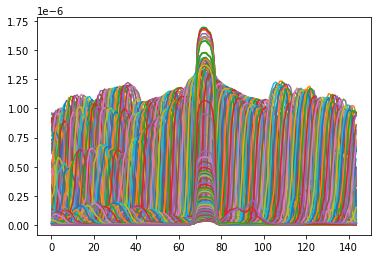

In [468]:
# Run as of 8/4/2022 -> Angle sweep - Long scans
start_time = time.time()
lens_scan_width = 14.
lens_dx = .1
lens_num_measurements = int( lens_scan_width / lens_dx)+1
powermeter_dx = 1.
drot = 10
rot_scan = 40.
if drot  ==0:
    rot_num_scan=1
else:
    rot_num_scan = int( rot_scan / drot)+1

base_file_name = '_stripmetalenshybrid2_pm_20ns_15sweeps.csv'
run_num = 4048
current_rot = 0.0

exp.Align()
exp.RotateLens(-rot_scan/2)
total_rot = -rot_scan/2
for rot_scan in range(rot_num_scan):
    exp.lens_motor.MoveMotor(-lens_scan_width/2.)
    if total_rot != 1000.:
        for lens_scan in range(lens_num_measurements):

            exp.Align('powermeter')
            position_lens = exp.lens_motor.GetCurrentPosition()
       
            powermeter_scan_width = 145. # mm
            powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
            position_led, positions_powermeter, maxes = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
            file_name = 'run'+str(run_num)+base_file_name
            SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, total_rot)       
            exp.lens_motor.MoveMotor(lens_dx)
            plt.plot(np.array(positions_powermeter), maxes) 
            run_num += 1
    exp.Align('lens')
    exp.RotateLens(drot)
    total_rot=total_rot+drot
    

exp.Align()
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

In [467]:
exp.RotateLens(10)

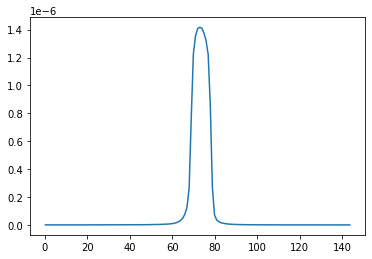

In [412]:
plt.plot(np.array(positions_powermeter), maxes) 


In [127]:
exp.RotateLens(-20)

'25/25'

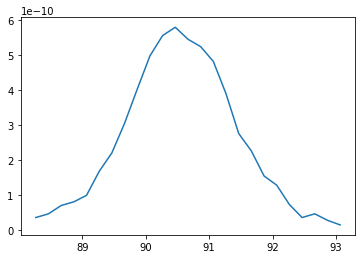

In [305]:
exp.Align()
displacement = 1.;
powermeter_scan_width = 5. # mm
powermeter_dx = .2
powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
do = FirstOrderDisplacement(displacement)
exp.powermeter_motor.MoveMotor(-do)
exp.lens_motor.MoveMotor(displacement)
#exp.led_motor.MoveMotor(1.)

position_led3, positions_powermeter3, maxes3 = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
plt.plot(positions_powermeter3,maxes3)


In [460]:
# Run as of 06/06/2022
# Substrate only
start_time = time.time()
lens_scan_width = 6.
lens_dx = 1.5
lens_num_measurements = int( lens_scan_width / lens_dx)
powermeter_dx = 1
base_file_name = '_substratestrip_20ns_15sweeps.csv'
run_num = 4044
current_rot = 0.0
led_displacement_y = -2.

exp.Align()
exp.led_motor.MoveMotor(led_displacement_y) #Moving LED 2mm up to take substrate data 
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for lens_scan in range(lens_num_measurements):
    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
    powermeter_scan_width = 20. # mm
    powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
    position_led, positions_powermeter, maxes = exp.ScanPower(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)   
    exp.lens_motor.MoveMotor(lens_dx)
    run_num += 1
    exp.led_motor.MoveMotor(.2)

    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
exp.Align()
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'20/20'

Total run time = 0.949691899617513


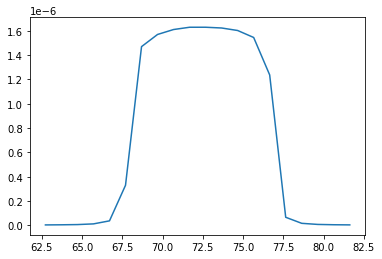

In [461]:
plt.plot(np.array(positions_powermeter), maxes) 


In [2368]:
# Run as of 06/06/2022
# Air only
start_time = time.time()
lens_scan_width = 15.
lens_dx = 15.
lens_num_measurements = int( lens_scan_width / lens_dx)
powermeter_dx = 1
base_file_name = '_air_50ns_15sweeps.csv'
run_num = 1798
current_rot = 0.0
led_displacement_y = 0.

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(lens_center - exp.led_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(led_displacement_y) #Moving LED 2mm up to take substrate data 
exp.lens_motor.MoveMotor(-lens_scan_width)
for lens_scan in range(lens_num_measurements):
    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
    powermeter_scan_width = 10. # mm
    powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
    position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
   
    
    exp.lens_motor.MoveMotor(lens_dx)
    run_num += 1
    #print(rot, lens_scan, current_rot)

exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.led_motor.MoveMotor(-led_displacement_y)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

'50/50'

Total run time = 0.8616413354873658


'150/150'

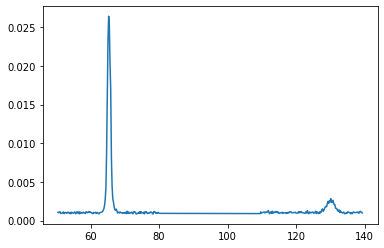

Total run time = 153.42918025652568


In [2687]:
# Run as of 6/7/2022 angle
start_time = time.time()
lens_scan_width = 8.
lens_dx = .25
lens_num_measurements = int( lens_scan_width / lens_dx)
powermeter_dx = 0.2
base_file_name = '_stripmetalens_20deg_50ns_15sweeps.csv'
run_num = 1829
current_rot = 20.
exp.Align('rot')
exp.Align('powermeter')



exp.lens_motor.MoveMotor(lens_center_x - exp.lens_motor.GetCurrentPosition())
exp.RotateLens(current_rot)

exp.lens_motor.MoveMotor(-lens_scan_width/2.)
for lens_scan in range(lens_num_measurements):

    exp.Align('powermeter')
    position_lens = exp.lens_motor.GetCurrentPosition()
    display(position_lens - lens_center_x)
    if abs(position_lens - lens_center_x) <= 1.0:
        powermeter_scan_width = 60. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        file_name = 'run'+str(run_num)+base_file_name
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    else:
        powermeter_scan_width = 30. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led1, positions_powermeter1, maxes1 = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        display(lens_center_x - exp.lens_motor.GetCurrentPosition())
        first_order_pos = FirstOrderDisplacement_oblique( lens_center_x-exp.lens_motor.GetCurrentPosition(),-current_rot)
        display(first_order_pos)
        exp.powermeter_motor.MoveMotor(first_order_pos)
        powermeter_scan_width = 30. # mm
        powermeter_num_measurements = int(powermeter_scan_width / powermeter_dx)
        position_led2, positions_powermeter2, maxes2 = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=True)
        
        position_led =  [position_led1 , position_led2]
        positions_powermeter = positions_powermeter1 + positions_powermeter2
        maxes = maxes1+maxes2
        file_name = 'run'+str(run_num)+base_file_name       
        SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    
    exp.lens_motor.MoveMotor(lens_dx)
    run_num += 1
    #print(rot, lens_scan, current_rot)
    plt.plot(positions_powermeter,maxes)
    plt.show()
exp.RotateLens(-current_rot)
exp.lens_motor.MoveMotor(-lens_scan_width/2.)
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

In [308]:
exp.Align()

In [ ]:
a 

In [340]:
a = np.array([1,2, 3])
b = np.array([4,5,6])
c = np.concatenate((a,b))
c

array([1, 2, 3, 4, 5, 6])

In [319]:
lens_center

266.19

In [320]:
lens_center_x

276.0

In [329]:
exp.lens_motor.MoveMotor(40)

In [74]:
# Run with just substrate
start_time = time.time()
num_rots = 100
drot = 1.8
powermeter_scan_width = 15
powermeter_num_measurements = 50
base_file_name = '_substrate_100ns_15sweeps.csv'
run_num = 756

exp.Align('rot')
current_rot = -drot*num_rots/2
exp.RotateLens(current_rot)
for rot in range(num_rots):
    
    exp.Align('powermeter')
    exp.lens_motor.MoveMotor(center - exp.lens_motor.GetCurrentPosition())
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    run_num += 1 

    exp.Align('powermeter')
    exp.lens_motor.MoveMotor(center - 2 - exp.lens_motor.GetCurrentPosition())
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    run_num += 1

    exp.Align('powermeter')
    exp.lens_motor.MoveMotor(center + 2 - exp.lens_motor.GetCurrentPosition())
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_powermeter, maxes = exp.ScanMaxes(width=powermeter_scan_width, num_measurements=powermeter_num_measurements, print_progress=False)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, current_rot)
    run_num += 1
    
    exp.RotateLens(drot)  
    current_rot += drot

exp.Align('rot')
end_time = time.time()
print('Total run time = '+str((end_time-start_time)/60.))

Total run time = 331.5511262933413


'50/50'

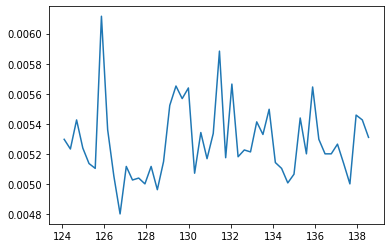

In [20]:
# Testing the new laser (5/13)
position_led, positions_powermeter, maxes = exp.ScanMaxes(width=15., num_measurements=50)
plt.plot(positions_powermeter, maxes)

In [21]:
exp.lens_motor.MoveMotor(40)

In [24]:
exp.powermeter_motor.MoveMotor(2)

In [14]:
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(10)
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveMotor(-10)
print(exp.lens_motor.GetCurrentPosition())

483.915
493.91
483.91


In [34]:
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveSteps(10)
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveSteps(-10)
print(exp.lens_motor.GetCurrentNumSteps())

90784
90794
90784


In [40]:
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveSteps(2000)
print(exp.lens_motor.GetCurrentPosition())
exp.lens_motor.MoveSteps(-2000)
print(exp.lens_motor.GetCurrentPosition())

473.915
483.915
473.915


In [41]:
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveMotor(10)
print(exp.lens_motor.GetCurrentNumSteps())
exp.lens_motor.MoveMotor(-10)
print(exp.lens_motor.GetCurrentNumSteps())

94783
96782
94782


In [15]:
print(exp.powermeter_motor.GetCurrentPosition())
exp.powermeter_motor.MoveMotor(10)
print(exp.powermeter_motor.GetCurrentPosition())
exp.powermeter_motor.MoveMotor(-10)
print(exp.powermeter_motor.GetCurrentPosition())

157.225
167.22
157.22


In [24]:
dx_per_step = 0.005
distance = 10.0
sign = distance / abs(distance)
num_steps = int(abs(distance) // dx_per_step)

In [38]:
10/.005

2000.0

In [32]:
dx_lens = 10.0 / 10.
num_steps = int(abs(dx_lens) // dx_per_step)

In [33]:
exp.

199

In [22]:
exp.Align()

LED motor is off. Switch motors to align


In [145]:
exp.powermeter_motor.MoveMotor(80)
exp.lens_motor.MoveMotor(-60)
exp.led_motor.MoveMotor(10)
exp.led_motor.MoveMotor(-10)

In [146]:
exp.led_motor.MoveMotor(-10)
exp.led_motor.MoveMotor(10)

In [144]:
exp.lens_motor.MoveMotor(60)

In [150]:
exp.SwitchMotor('rot')

Manually connect rot motor and disconnect led motor


In [324]:
exp.Align('lens')

In [141]:
exp.Rot

LED motor is off. Switch motors to align


In [142]:
exp.RotateLens(-20)

'180/180'

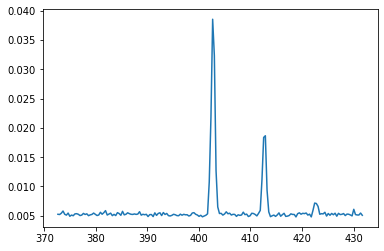

In [56]:
# Measure voltage at each distance
width = 60
num_measurements = 180
num_sweeps = 10
distance_to_move = width/num_measurements
maxes = []
positions_powermeter = []
position_led = led_motor.GetCurrentPosition()
powermeter_motor.MoveMotor(-width/2.)
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    powermeter_motor.MoveMotor(distance_to_move)
    maxes.append(osc.MeasurePeaktoPeak(scope, num_sweeps))
    positions_powermeter.append(powermeter_motor.GetCurrentPosition())
powermeter_motor.MoveMotor(-width/2.)
plt.plot(positions_powermeter, maxes)

# Linearity Run
This run takes data to find the linearity of the powermeter at a given LED width for different LED voltages. 

In [143]:
exp.lens_motor.MoveMotor(-40)

In [162]:
values = []
num_voltages = 59
step_size = 0.1
start_voltage = 0.1
end_voltage = 6.0  
voltage_range = np.arange(start_voltage, end_voltage,step_size)
for i in range(num_voltages):
    scope.timeout = 5000
    scope.clear()
    r = scope.query(r"""vbs? 'return=app.WaitUntilIdle(5)' """)
    values.append(osc.MeasurePeaktoPeak(scope, 50)) #- dark_count
    
    clear_output(wait=True)
    display('Turn Knob to '+str(start_voltage+(1+i)*step_size)+ 'V')
    time.sleep(2)

'Turn Knob to 6.0V'

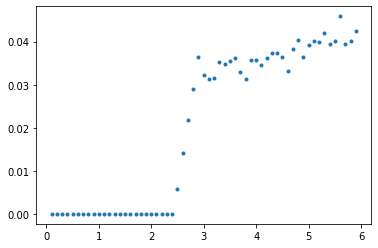

In [163]:
plt.plot(voltage_range, values,  '.') # powermeter slit closed most of the way

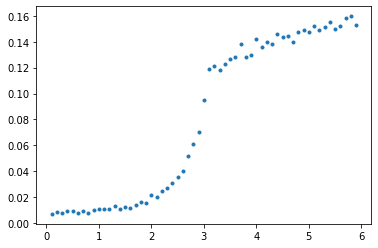

In [160]:
plt.plot(voltage_range, values,  '.') # powermeter slit all the way open, lens out of the way (saved)

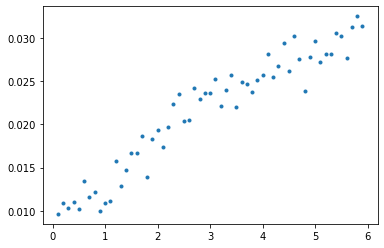

In [147]:
plt.plot(voltage_range, values[0:59],  '.') # lens out of the way

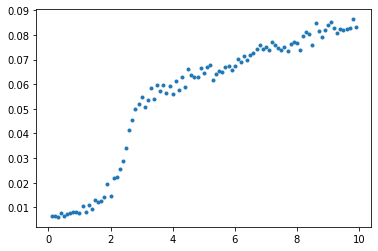

In [140]:
plt.plot(voltage_range, values,  '.') # lens in the way and tilted (saved)

In [161]:
file_name = 'linearity_100ns_0.1_6V.csv'
with open(file_name, mode='w') as file:
    writer = csv.writer(file)
    
    writer.writerow(values)

### Saving Data

In [20]:
file_name = 'run03_metalens_100ns_10sweeps.csv'
def SaveScanMaxesData(file_name, position_lens, position_led, positions_powermeter, maxes, rot_angle):
    with open('data/'+file_name, mode='w') as file:
                writer = csv.writer(file)
                
                writer.writerow(['position_lens'])
                writer.writerow([position_lens]) 
                writer.writerow(['position_led'])
                writer.writerow([position_led])
                writer.writerow(['positions_powermeter'])
                writer.writerow(positions_powermeter)
                writer.writerow(['maxes'])
                writer.writerow(maxes)
                writer.writerow(['rotation'])
                writer.writerow([rot_angle])

# Close after done running

In [ ]:
# Make sure to close the connection (in teh reverse order of setting it up)
scope.close()
rm.close()